In [1]:
using ModelingToolkit

# Stochastic description of the Van der Pol oscillator

@variables t, x₁(t), x₂(t)
@parameters ϵ, ω_n, ω_g, A

drift_eqs = [Differential(t)(x₁) ~ x₂;
             Differential(t)(x₂) ~ ϵ*(1-x₁^2)*x₂ - ω_n^2*x₁ + A*cos(ω_g*t)]
diff_eqs = [0; A]

vdp_model = SDESystem(drift_eqs, diff_eqs, t, [x₁, x₂], [ϵ, ω_n, ω_g, A], name = :VdP)

ps = [ϵ => 0.1, ω_n => 120*pi, ω_g => 120*pi, A => 2.5] # parameter values
u0 = [0.1, 0.1]   # initial conditions
tspan = (0., 0.1) # simulation time limit

(0.0, 0.1)

In [2]:
using MomentClosure, Latexify

moment_eqs = generate_raw_moment_eqs(vdp_model, 2) 
latexify(moment_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& \mu{_{01}} \\
\frac{d\mu{_{01}}}{dt} =& A \cos\left( t \omega_{g} \right) + \epsilon \mu{_{01}} - \epsilon \mu{_{21}} - \omega_{n}^{2} \mu{_{10}} \\
\frac{d\mu{_{20}}}{dt} =& 2 \mu{_{11}} \\
\frac{d\mu{_{11}}}{dt} =& \epsilon \mu{_{11}} + A \mu{_{10}} \cos\left( t \omega_{g} \right) + \mu{_{02}} - \epsilon \mu{_{31}} - \omega_{n}^{2} \mu{_{20}} \\
\frac{d\mu{_{02}}}{dt} =& A^{2} + 2 \epsilon \mu{_{02}} + 2 A \mu{_{01}} \cos\left( t \omega_{g} \right) - 2 \omega_{n}^{2} \mu{_{11}} - 2 \epsilon \mu{_{22}}
\end{align*}
"

In [3]:
println(latexify(moment_eqs))

\begin{align*}
\frac{d\mu{_{10}}}{dt} =& \mu{_{01}} \\
\frac{d\mu{_{01}}}{dt} =& A \cos\left( t \omega_{g} \right) + \epsilon \mu{_{01}} - \epsilon \mu{_{21}} - \omega_{n}^{2} \mu{_{10}} \\
\frac{d\mu{_{20}}}{dt} =& 2 \mu{_{11}} \\
\frac{d\mu{_{11}}}{dt} =& \epsilon \mu{_{11}} + A \mu{_{10}} \cos\left( t \omega_{g} \right) + \mu{_{02}} - \epsilon \mu{_{31}} - \omega_{n}^{2} \mu{_{20}} \\
\frac{d\mu{_{02}}}{dt} =& A^{2} + 2 \epsilon \mu{_{02}} + 2 A \mu{_{01}} \cos\left( t \omega_{g} \right) - 2 \omega_{n}^{2} \mu{_{11}} - 2 \epsilon \mu{_{22}}
\end{align*}



In [6]:
using DifferentialEquations

closed_eqs = moment_closure(moment_eqs, "derivative matching")

u0map = deterministic_IC(u0, closed_eqs)
oprob = ODEProblem(closed_eqs, u0map, tspan, ps)

sol_MA = solve(oprob, Tsit5(), saveat=0.0001);

  0.370875 seconds (110.32 k allocations: 13.105 MiB)


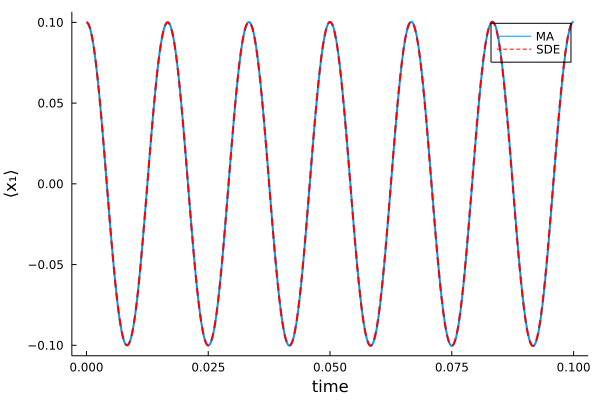

In [7]:
using DifferentialEquations.EnsembleAnalysis, Plots

prob_SDE = SDEProblem(vdp_model, u0, tspan, ps)
@time sol_SDE = solve(EnsembleProblem(prob_SDE), SRIW1(), saveat=0.0001, trajectories=100)
means_SDE = timeseries_steps_mean(sol_SDE)

plot(sol_MA.t, sol_MA[1, :], lw=2, label="MA", ylabel="⟨x₁⟩", xlabel="time")
plot!(sol_MA.t, means_SDE[1, :], lw=2, label="SDE", linecolor=:red,
      linestyle=:dash, background_color_legend=nothing, legend=:topright, grid=false)

In [8]:
@variables t, x₁(t), x₂(t)
@parameters k, l, m, g

drift_eqs = [Differential(t)(x₁) ~ x₂;
             Differential(t)(x₂) ~ -k/m*x₂ - g/l*sin(x₁)]
diff_eqs = [0; 1/m]

pendulum_model = SDESystem(drift_eqs, diff_eqs, t, [x₁, x₂], [k, l, m, g], name = :pendulum)
ps = [k => 10, m => 10, l => 10, g => 10]
u0 = [3, 3]
tspan = (0., 15.)

(0.0, 15.0)

In [9]:
moment_eqs = generate_central_moment_eqs(pendulum_model, 2, 3) 
latexify(moment_eqs) # the output here is maybe not the most visually pleasing

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& \mu{_{01}} \\
\frac{d\mu{_{01}}}{dt} =& \frac{\left(  - k \right) \mu{_{01}}}{m} + \frac{\left(  - g \right) \sin\left( \mu{_{10}} \right)}{l} + \frac{\frac{1}{6} g M{_{30}} \cos\left( \mu{_{10}} \right)}{l} + \frac{\frac{1}{2} g M{_{20}} \sin\left( \mu{_{10}} \right)}{l} \\
\frac{dM{_{20}}}{dt} =& 2 M{_{11}} \\
\frac{dM{_{11}}}{dt} =& \frac{\left(  - k \right) M{_{11}}}{m} + \frac{\left(  - g \right) M{_{20}} \cos\left( \mu{_{10}} \right)}{l} + \frac{\frac{1}{2} g M{_{30}} \sin\left( \mu{_{10}} \right)}{l} + M{_{02}} \\
\frac{dM{_{02}}}{dt} =& \frac{\frac{1}{1}}{m^{2}} + \frac{-2 k M{_{02}}}{m} + \frac{g M{_{21}} \sin\left( \mu{_{10}} \right)}{l} + \frac{-2 g M{_{11}} \cos\left( \mu{_{10}} \right)}{l}
\end{align*}
"

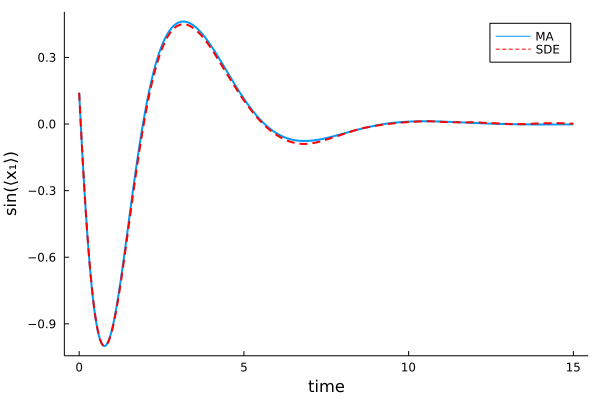

In [10]:
closed_eqs = moment_closure(moment_eqs, "gamma")

u0map = deterministic_IC(u0, closed_eqs)
oprob = ODEProblem(closed_eqs, u0map, tspan, ps)
sol_MA = solve(oprob, Tsit5(), saveat=0.01)

prob_SDE = SDEProblem(pendulum_model, u0, tspan, ps)
sol_SDE = solve(EnsembleProblem(prob_SDE), SRIW1(), saveat=0.01, trajectories=100)
means_SDE = timeseries_steps_mean(sol_SDE)

plot(sol_MA.t, sin.(sol_MA[1, :]), lw=2, label="MA", ylabel="sin(⟨x₁⟩)", xlabel="time")
plot!(sol_MA.t, sin.(means_SDE[1, :]), lw=2, label="SDE", linecolor=:red,
    linestyle=:dash, background_color_legend=nothing, legend=:topright, grid=false)